<a href='https://ai.meng.duke.edu'> = <img align="left" style="padding-top:10px;" src=https://storage.googleapis.com/aipi_datasets/Duke-AIPI-Logo.png>

# Data Preparation and Model Training

In [1]:
import os
from google.colab import drive
from google.colab import files

#for image processing
!pip install pillow
import random
import numpy as np
import tensorflow as tf
from PIL import Image
from matplotlib import pyplot as plt

#for metadata
import pandas as pd

#for data file structure
!pip install pip install split-folders
import splitfolders
import shutil

#for modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import Subset, DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchsummary import summary

#for metrics
from sklearn.metrics import mean_squared_error

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Step 1: Link Notebook to GitHub and Google Drive

In [3]:
# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "BrainAgingComputerVision" # Enter repo name
git_path = 'https://github.com/MRWilliamsGit/BrainAgingComputerVision.git'
!git clone "{git_path}"

#!pip install -r "{os.path.join(repo_name,'requirements.txt')}"

# Connect to Google Drive
drive.mount('/content/gdrive')
#%cd gdrive/MyDrive/School

Cloning into 'BrainAgingComputerVision'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 146 (delta 13), reused 36 (delta 13), pack-reused 110
Receiving objects: 100% (146/146), 104.57 MiB | 20.18 MiB/s, done.
Resolving deltas: 100% (59/59), done.
Mounted at /content/gdrive


## Step 2: Data Prep

### A) Show some images

In [4]:
#pull up image metadata
filein = '/content/gdrive/My Drive/School/cn_age_df.csv'
data = pd.read_csv(filein)
#data.head()

In [ ]:
#to reset:
#shutil.rmtree("/content/image_data")

In [5]:
#import files (1267 files)
#note that naming convention includes "test" and "val" but that is not for this project
!unzip '/content/gdrive/My Drive/School/image_data.zip' > /dev/null

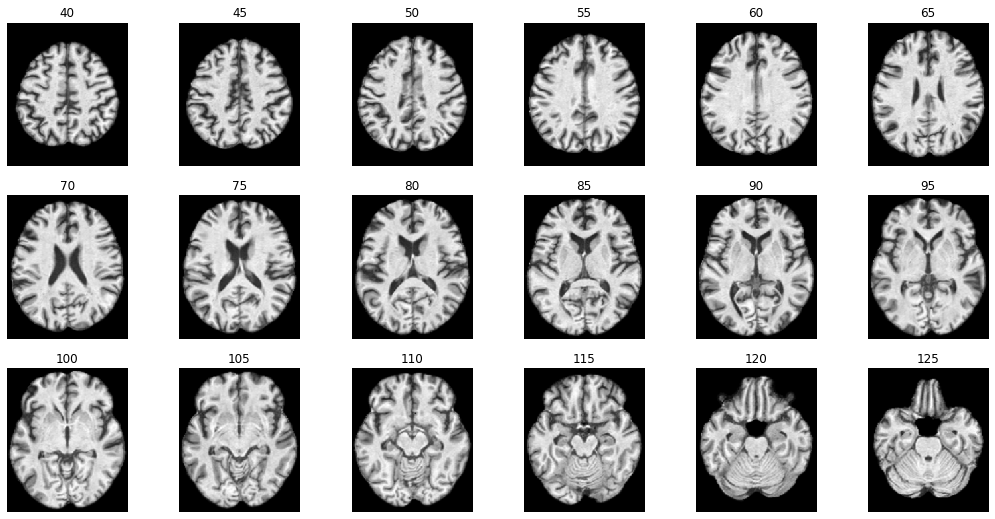

In [8]:
#pick a 3D image to take a look at
image_path = '/content/image_data/0_A_train.npy'
image3D = np.load(image_path)

#show image size (218*182*182)
#print(image3D.size)

#loop to show slices in 5 slice increments
start_sl = 40
plt.rcParams['figure.figsize'] = [18, 9]
fig, axs = plt.subplots(3, 6)
for m in range(3):
  for w in range(6):
    im = Image.fromarray((image3D[start_sl] * 255).astype(np.uint8))
    im = np.rot90(im)
    axs[m, w].imshow(im, interpolation='nearest', cmap='gray')
    axs[m, w].set_title(str(start_sl))
    axs[m, w].axis('off')
    start_sl += 5

fig.savefig("slices2.png")

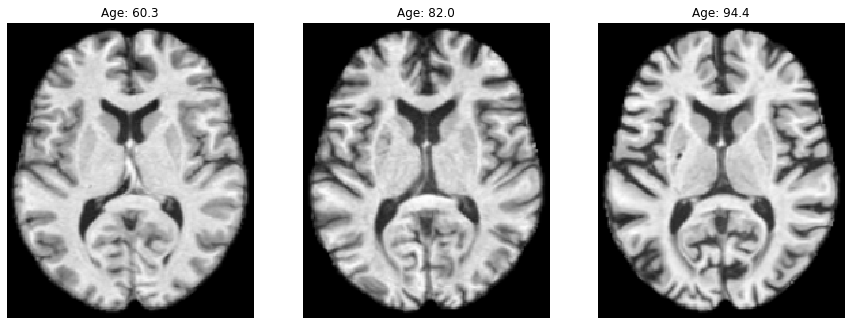

In [9]:
#display different ages for reference
#60, 82, 94

images = ['/content/image_data/1488_A_train.npy', '/content/image_data/452_N_train.npy', '/content/image_data/156_T_train.npy']

plt.rcParams['figure.figsize'] = [15, 8]
fig, axs = plt.subplots(1, 3)
i=0
for m in images:
  #get image
  image_3D = np.load(m)
  im = Image.fromarray((image_3D[85] * 255).astype(np.uint8))
  im = np.rot90(im)
  axs[i].imshow(im, interpolation='nearest', cmap='gray')
  #get title
  imgn = m.split("/")[-1]
  imgn = imgn.split(".")[0]
  line = data.loc[data['Data ID'] == imgn]
  label = line.iloc[0][5]
  axs[i].set_title("Age: " + str(label))
  axs[i].axis('off')
  i += 1

fig.savefig("3ages.png")


### B) sort files, manipulate in custom class, load in dataloaders

In [10]:
#divide files into training and test sets, ratio: 90/10
#note this does not ensure that classes are equivalently represented
flist = os.listdir('/content/image_data/')
random.shuffle(flist)
tlen = round(len(flist)*.9)
tlist = flist[0:tlen]
vlist = flist[tlen:len(flist)]
os.mkdir('/content/image_data/train/')
os.mkdir('/content/image_data/val/')

for f in tlist:
  imgpl1 = "/content/image_data/" + f
  imgpl2 = "/content/image_data/train/" + f
  os.rename(imgpl1, imgpl2)
for f in vlist:
  imgpl1 = "/content/image_data/" + f
  imgpl2 = "/content/image_data/val/" + f
  os.rename(imgpl1, imgpl2)

In [11]:
#define class for the images
class BrainBits(Dataset):

  #receives the folder of images, the csv file of data, and the transform
  def __init__(self, img_path, label_file, transform):
    self.root = img_path
    self.data_paths = [f for f in sorted(os.listdir(img_path))]
    self.dataf = label_file
    self.transform = transform

  def __getitem__(self, idx):

    #get file then set 85 slice as image
    imgpath = self.root + self.data_paths[idx]
    image3D = np.load(imgpath)
    img = Image.fromarray((image3D[85] * 255).astype(np.uint8))

    #get name of file
    imgn = self.data_paths[idx].split(".")
    imgn = imgn[0]

    #find filename in dataf, set age as label
    line = self.dataf.loc[self.dataf['Data ID'] == imgn]
    label = line.iloc[0][5]

    #apply transform
    if self.transform:
      img = self.transform(img)
    return img, label

  def __len__(self):
    return len(self.data_paths)

In [12]:
#define transformation - same for both train and val
data_transform = transforms.Compose([ transforms.Resize((224, 224)),
                                         transforms.Grayscale(),
                                         transforms.ToTensor(),
                                         transforms.Normalize(mean=[0.5],std=[0.5])])

In [13]:
#get data
train_data = BrainBits(img_path='/content/image_data/train/', label_file=data, transform=data_transform)
test_data = BrainBits(img_path='/content/image_data/val/', label_file=data, transform=data_transform)

#make loaders
batch_size = 32
train_loader = torch.utils.data.DataLoader(train_data, batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size, shuffle=True)

# Store size of training set
dataset_size = len(train_data)


torch.Size([32, 1, 224, 224])


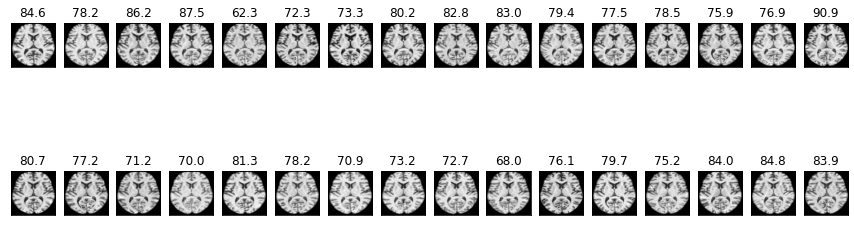

In [14]:
# Visualize a batch of images 
# note: they were compressed sideways, and yes, ages were recorded to a decimal
images, labels = iter(train_loader).next()
print(images.shape)

# plot the images in the batch, along with the corresponding labels
# note that images are greyscale, it's just the plot aesthetic that makes them colorful
fig = plt.figure(figsize=(15, 5))
for idx in range(batch_size):
    ax = fig.add_subplot(2, batch_size//2, idx+1, xticks=[], yticks=[])
    im = np.squeeze(images[idx])
    im = np.rot90(im)
    ax.imshow(im, cmap='gray')
    ax.set_title(labels[idx].tolist())

## Step 3: Define and Train Model

In [ ]:
#train function
def train_model2(model,criterion,optimizer,loader,n_epochs,device):
    
    loss_over_time = [] # to track the loss as the network trains
    model = model.to(device) # Send model to GPU if available
    model.train() # Set the model to training mode
    
    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0
        
        for i, data in enumerate(loader):
            
            # Get the input images and labels, and send to GPU if available
            inputs, labels = data[0].to(device), data[1].to(device)
            labels.resize_(len(labels), 1)

            # Zero the weight gradients
            optimizer.zero_grad()

            # Forward pass to get outputs
            outputs = model.forward(inputs)

            # Calculate the loss
            loss = criterion(outputs, labels.float())

            # Backpropagation to get the gradients with respect to each weight
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # Collect loss
            running_loss += loss.item()
            
        # Calculate and display average loss for the epoch
        epoch_loss = running_loss / len(loader)
        print('Loss: {:4f}'.format(epoch_loss))

        loss_over_time.append(epoch_loss)

    return loss_over_time

In [ ]:
# Load a resnet18 pre-trained model
regmodel = torchvision.models.resnet18(pretrained=True)

# Shut off autograd for all layers to freeze model so the layer weights are not trained
for param in regmodel.parameters():
    param.requires_grad = False
    
# Replace the resnet input layer to take in grayscale images (1 input channel), since it was originally trained on color (3 input channels)
in_channels = 1
regmodel.conv1 = nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Replace the resnet final layer with a new fully connected Linear layer we will train on our task
# Number of out units is 1 because regression
num_ftrs = regmodel.fc.in_features
regmodel.fc = nn.Linear(num_ftrs, 1)


Loss: 234.771037
Loss: 47.355222
Loss: 39.809656
Loss: 36.689202
Loss: 32.891910
Loss: 33.074607
Loss: 32.955210
Loss: 30.390188
Loss: 29.434824
Loss: 26.969457
Loss: 25.733629
Loss: 26.064011
Loss: 24.218996
Loss: 24.575353
Loss: 23.078138
Loss: 22.951943
Loss: 22.610376
Loss: 21.914485
Loss: 20.608701
Loss: 19.872107
Loss: 19.115109
Loss: 20.484734
Loss: 18.598161
Loss: 19.158256
Loss: 18.094039


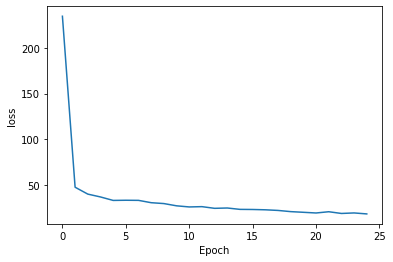

In [ ]:
# Train the model
n_epochs = 25
criterion = nn.MSELoss()
optimizer = optim.SGD(regmodel.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
cost_path = train_model2(regmodel,criterion,optimizer,train_loader,n_epochs,device)

# Visualize the loss as the network trains
plt.plot(cost_path)
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.show()

In [ ]:
# Function to get predictions
def get_results(model,dataloader,device):
    model = model.to(device) # Send model to GPU if available
    with torch.no_grad():
        model.eval()
        # Get a batch of validation images
        images, labels = iter(dataloader).next()
        images, labels = images.to(device), labels.to(device)
        # Get predictions
        preds = model(images)
        preds = np.squeeze(preds.cpu().numpy())
        preds = np.around(preds, decimals=1)
        labels = labels.cpu().numpy()
    
    return preds, labels

# Function to display a batch of predictions
def visualize_results(preds, labels):

    fig = plt.figure(figsize=(15, 10))
    for idx in np.arange(len(preds)):
        #images
        ax = fig.add_subplot(4, len(preds)//4, idx+1, xticks=[], yticks=[])
        image = images[idx]
        image = image.permute(1,2,0).cpu().numpy() # Permute axes because im.show() expects dims [W,H,C] and PyTorch/NumPy use [C,W,H]
        mean = np.array([0.5])
        std = np.array([0.5])
        image = tf.convert_to_tensor(std) * image + tf.convert_to_tensor(mean)
        image = np.clip(image, 0, 1)
        image = np.squeeze(image)
        image = im = np.rot90(im)
        ax.imshow(image, cmap='gray')
        #titles
        line = str(preds[idx])+" ("+str(labels[idx])+")"
        ax.set_title(line, color=("green" if abs(preds[idx]-labels[idx])<=4 else "red"))
    return

Test set MSE: 21.82000335693708


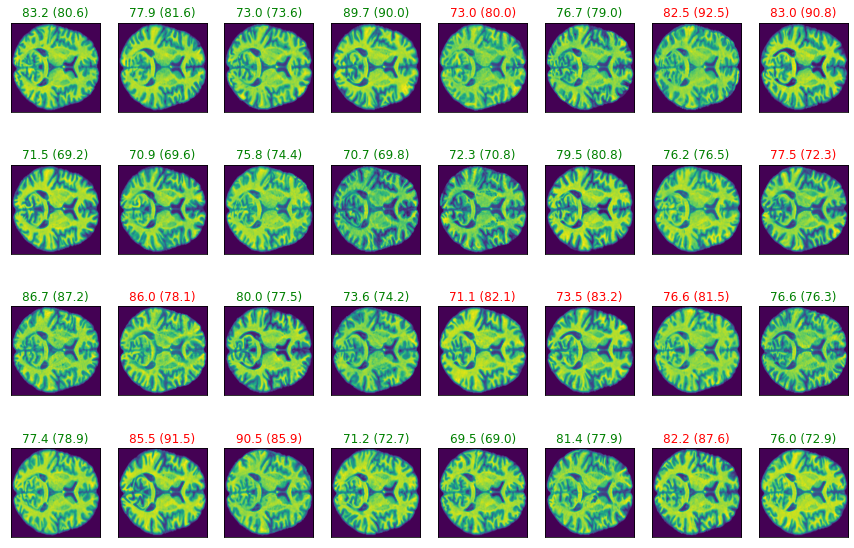

In [ ]:
#test and display results
preds, labels = get_results(regmodel,test_loader,device)
print('Test set MSE: '+ str(mean_squared_error(labels,preds)))

visualize_results(preds, labels)